In [99]:
#【数据处理】
import pandas as pd
data = pd.read_csv('datasets/train.csv')
# print("max_user_id:",data.user_id.max())
# print("max_item_id:",data.item_id.max())
print(data,'\n')
data.iloc[:,:]+=1 #将两列所有元素都+1
max_user_id=data.user_id.max()
max_item_id=data.item_id.max()
print(data,'\n')
data.to_csv("data/book.txt",index=0,header=0,sep=' ')

print("max_user_id:",max_user_id)
print("max_item_id:",max_item_id)

         user_id  item_id
0              0      257
1              0      267
2              0     5555
3              0     3637
4              0     1795
...          ...      ...
5869626    49801     4655
5869627    49801     5091
5869628    49801     5294
5869629    49801     5608
5869630    49801     5683

[5869631 rows x 2 columns] 

         user_id  item_id
0              1      258
1              1      268
2              1     5556
3              1     3638
4              1     1796
...          ...      ...
5869626    49802     4656
5869627    49802     5092
5869628    49802     5295
5869629    49802     5609
5869630    49802     5684

[5869631 rows x 2 columns] 

max_user_id: 53424
max_item_id: 10000


In [101]:
#【训练】
%run main.py --dataset=book --train_dir=trainstatus --num_epochs=50 --eval_epochs=5 --device=cuda

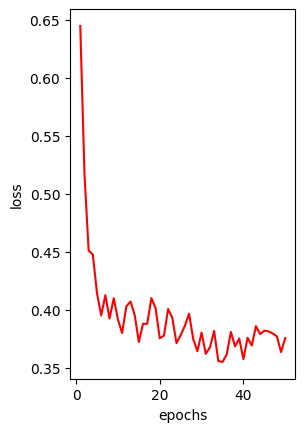

In [ ]:
import matplotlib.pyplot as plt

epoch,loss=[],[]
with open("./book_trainstatus/log_datailed.txt","r") as file:
    for line in file:
        if "epoch=" in line and "loss=" in line:
            tmp=line.split()
            epoch.append(int(tmp[0].replace("epoch=","").replace(":","")))
            loss.append(float(tmp[1].replace("loss=","")))

plt.subplot(1,2,1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epoch, loss, 'r')

plt.show()

In [4]:
#【载入模型参数】
from model import SASRec
import torch
class args():
    def __init__(self):
        self.dataset = 'book'
        self.train_dir = 'trainstatus'
        self.batch_size = 128
        self.lr = 0.001
        self.maxlen = 200
        self.hidden_units = 50
        self.num_blocks = 2
        self.num_epochs = 50
        self.eval_epochs = 5
        self.num_heads  = 1
        self.dropout_rate = 0.2
        self.l2_emb = 0.0
        self.inference_only = False
        self.state_dict_path = './book_trainstatus/SASRec.epoch=40.lr=0.001.layer=2.head=1.hidden=50.maxlen=200.pth'
        self.device = 'cuda'

args=args()
#max_user_id: 53424
#max_item_id: 10000
model = SASRec(53424, 10000, args).to(args.device)
model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
model.eval()

SASRec(
  (item_emb): Embedding(10001, 50, padding_idx=0)
  (pos_emb): Embedding(201, 50, padding_idx=0)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (attention_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (attention_layers): ModuleList(
    (0-1): 2 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
  )
  (forward_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (forward_layers): ModuleList(
    (0-1): 2 x PointWiseFeedForward(
      (conv1): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout1): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (last_layernorm): LayerNorm((50,), eps=1e-08, elementwise_affine=True)
)

In [5]:
#【构造预测结果】
from tqdm import tqdm
from collections import defaultdict

usernum = 0
itemnum = 0
User = defaultdict(list)
# assume user/item index starting from 1
f = open('data/book.txt', 'r')
lines = f.readlines()
for line in tqdm(lines):
    u, i = line.rstrip().split(' ')
    u = int(u)
    i = int(i)
    usernum = max(u, usernum)
    itemnum = max(i, itemnum)
    User[u].append(i)
f.close()

100%|██████████| 5869631/5869631 [00:06<00:00, 949067.06it/s] 


In [7]:
#【构造预测结果】
from model import SASRec
import numpy as np
from tqdm import tqdm
import torch

file = open('./submission.csv','w')
file.write('user_id,item_id'+'\n')
add_item=set(range(1, itemnum+1))
with torch.no_grad():
    for u in tqdm(range(1,usernum+1)):
        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        for i in reversed(User[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break
        
        pred_item = list(add_item-set(User[i]))
        pred_item = np.array(pred_item)
        length = len(pred_item)
        u_np,seq = np.array(u),np.array([seq])

        preds = model.predict(*[u_np, seq, pred_item])[0].detach().cpu()
        preds_max = np.array(-preds).argsort()[:10]
        ans = np.array(pred_item)[preds_max]
        ans.sort()
        # print("{}: {}".format(u-1,ans-1))
        output = "\n".join(["{},{}".format(u-1,i-1) for i in ans])
        file.write(output+'\n')
file.close()


100%|██████████| 53424/53424 [02:05<00:00, 427.21it/s]
